In [11]:
print("Hi") #Predicting the probability of a claim in the next year and then 3 yrs. Also, bring in additional details about what kind of claim based on the coverage column.

Hi


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from IPython.display import display

df = pd.read_excel('EMEA Claims History Data set - Test.xlsx')
#Claims data from excel
print(df)

      INSURED FIRST NAME INSURED LAST NAME INSURED DATE OF BIRTH  \
0                  raghu              test   1981-12-01 00:00:00   
1                  raghu              test   1981-12-01 00:00:00   
2                  raghu              test   1981-12-01 00:00:00   
3                  raghu              test   1981-12-01 00:00:00   
4                  raghu              test   1981-12-01 00:00:00   
...                  ...               ...                   ...   
45012             Zuzana         Valentova   1968-03-29 00:00:00   
45013             Zuzana         Valentova   1968-03-29 00:00:00   
45014             Zuzana         Valentova   1968-03-29 00:00:00   
45015             Zuzana         Valentova   1968-03-29 00:00:00   
45016             Zuzana         Valentova   1968-03-29 00:00:00   

      INSURED ID NUMBER BIRTHDAY ID(SAME AS INSURED ID NUMBER) CLAIM NUMBER  \
0           856018/1817                            856018/1817    17.002056   
1           856018/1817  

In [13]:
#Created new dataframe that groups based on each unique insured ID number and then aggregates conditional number of claims depending on the type of claim for each column.
claimsdf = df.groupby(['INSURED ID NUMBER']).apply(lambda x: pd.Series(dict(
    Disease_Claims=(x.CATEGORY == "D").sum(),
    Accident_Claims=(x.CATEGORY == "A").sum(),
    Outpatient_Care_Claims=(x.CATEGORY == "OC").sum(),
    Ordinary_Death_Claims=(x.CATEGORY == "OD").sum(),
    Credit_Life_Claims=(x.CATEGORY == "Y").sum(),
    Accident_Death_Claims=(x.CATEGORY == "AD").sum(),
    Travel_Insurance_Claims=(x.CATEGORY == "T").sum(),
    Past_Yr_Claims=(x["EVENT DATE"]>20210000).sum(),
    Lifetime_Claims=(x.CATEGORY != "").sum(),
)))
claimsdf

,Disease_Claims,Accident_Claims,Outpatient_Care_Claims,Ordinary_Death_Claims,Credit_Life_Claims,Accident_Death_Claims,Travel_Insurance_Claims,Past_Yr_Claims,Lifetime_Claims
INSURED ID NUMBER,,,,,,,,,
000101/6928,1,0,0,1,2,1,0,4,6
000104/3361,0,0,4,0,0,0,0,0,4
000104/3757,4,0,0,0,0,0,0,0,4
000111/4223,0,0,0,0,0,24,0,4,352
000121/6369,0,0,4,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...
996101/0983,0,3,0,0,0,0,0,0,3
996102/1323,0,0,0,0,0,0,0,10,10
996130/1009,2,2,0,0,0,0,0,2,4


In [14]:
#To find the unique categories to group for the dataframe above
test = df.groupby(['INSURED ID NUMBER', 'CATEGORY']).size()
new_df = test.to_frame(name='Num Of Claims').reset_index()
new_df
new_df['CATEGORY'].unique() # 99, 'AD', 'D', 'OD', 'Y', 'OC', 'A', 'T'

array([99, 'AD', 'D', 'OD', 'Y', 'OC', 'A', 'T'], dtype=object)

In [15]:
#Clustering method to identify patterns within customers based on their claims and coverage. Understand customer base more.
useful_claimsdf = claimsdf[ (claimsdf['Disease_Claims']>=0) & (claimsdf['Accident_Claims']>=0) & (claimsdf['Disease_Claims']<200) & (claimsdf['Accident_Claims']<200)]
print(useful_claimsdf.iloc[7])
X = useful_claimsdf[['Disease_Claims', 'Accident_Claims']].values #2 features for easier visualization of clusters (1 axis per feature)
X

Disease_Claims             0
Accident_Claims            2
Outpatient_Care_Claims     0
Ordinary_Death_Claims      0
Credit_Life_Claims         0
Accident_Death_Claims      0
Travel_Insurance_Claims    0
Past_Yr_Claims             0
Lifetime_Claims            2
Name: 000406/3906, dtype: int64


array([[ 1,  0],
       [ 0,  0],
       [ 4,  0],
       ...,
       [ 2,  2],
       [ 4,  2],
       [19,  3]], dtype=int64)

C:\Users\kghosh17\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


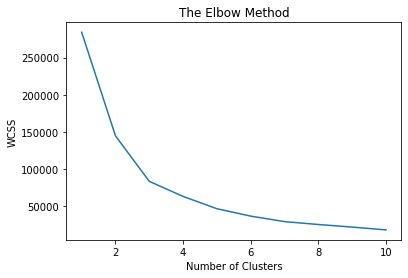

In [16]:
#Using elbow method to find optimal number of clusters for K-Means Algo
from sklearn.cluster import KMeans  #Run K-means algo several times with 10 different num of clusters
wcss = []   #Within Cluster Sum of Squares: sum of the squared distances between each observation pt of the cluster and the centroid of the cluster (for each of the num of clusters)
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) #Creating 10 different K-Mean objects for each cluster
    kmeans.fit(X) #Training K-means algo with i num of clusters
    wcss.append(kmeans.inertia_) #Get wcss value
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
#Training the K-Means model on the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42) #Creating 10 different K-Mean objects for each cluster
y_kmeans = kmeans.fit_predict(X) #Create dependent variable clusters
print(y_kmeans)

[0 0 0 ... 0 0 4]


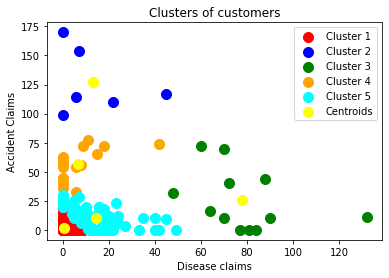

In [18]:
#Visualizing the clusters
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=100, c='orange', label='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=100, c='cyan', label='Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of customers')
plt.xlabel('Disease claims')
plt.ylabel('Accident Claims')
plt.legend()
plt.show()

In [19]:
def updateClusterTables(c):
    numCluster = c
    filtered = useful_claimsdf[y_kmeans==numCluster-1]
    print('Cluster '+str(numCluster)+" customers")
    display(filtered)
    
    joined = pd.merge(filtered, df, on="INSURED ID NUMBER", how='inner')
    joined = joined[pd.notnull(joined['Disease_Claims'])][df.columns]
    print('All claims from the cluster '+str(numCluster)+" customers")
    display(joined)

In [20]:
amp = widgets.IntSlider(min=1, max=5, description="Cluster: ")
widgets.interact(updateClusterTables, c=amp)

interactive(children=(IntSlider(value=1, description='Cluster: ', max=5, min=1), Output()), _dom_classes=('wid…

<function __main__.updateClusterTables(c)>

,Average Number of Disease Claims,Average Number of Accident Claims
Cluster 1,0.846078,1.421569
Cluster 2,13.333333,127.333333
Cluster 3,78.000000,25.416667
Cluster 4,6.764706,56.529412
Cluster 5,14.382716,10.148148


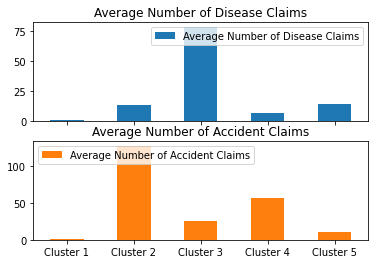

In [21]:
disease_claims = kmeans.cluster_centers_[:, 0].tolist()
accident_claims = kmeans.cluster_centers_[:, 1].tolist()
index = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
barplotdf = pd.DataFrame({"Average Number of Disease Claims": disease_claims, "Average Number of Accident Claims": accident_claims}, index=index)
axes = barplotdf.plot.bar(rot=0, subplots=True)
axes[1].legend(loc=2)
barplotdf

In [22]:
from platform import python_version
print(python_version())

3.9.12
